# Updraft-downdraft coupling

Thomas Schanzer  
January 2022

In this notebook we explore approaches to coupling downdrafts to updrafts in our scheme. After a review of relevant literature, we have formulated the following conclusions and questions:
- Updrafts should trigger downdrafts by the evaporation of precipitation (Windmiller et al., Cotton et al. 2011, Knupp and Cotton 1985)
    - The precipitation can descend from higher levels (Knupp and Cotton 1985)
- Precipitation-driven downdrafts should be initiated at low levels (Torri and Kuang 2016, Cotton et al. 2011, Knupp and Cotton 1985)
    - Torri and Kuang 2016: below ~2.5 km, peak around 1 km
    - Barnes and Garstang 1982 (in Knupp and Cotton 1985): near or below 750 mbar
    - Knupp and Cotton 1985: 2-5 km or 1.5-4.0 km
- Downdrafts could initiate at or below the level of minimum theta-e (Sud and Walker 1993, Zipser 1969 in Cotton et al. 2011)
- Since precipitation-associated downdrafts usually only exist at low levels, we need to consider other initiation mechanisms that generate elevated updrafts (Knupp and Cotton 1985)
    - Elevated downdrafts could be generated by overshooting updrafts (Cotton et al. 2011, Knupp and Cotton 1985)
- Can we model up-down downdrafts, whose air was previously much lower than the initiation level? (Cotton et al. 2011)
- Could averaging an ensemble of downdrafts (and/or updrafts) with a range of deterministically or stochastically chosen parameters give more realistic results, given the wide variation in updraft properties and their high correlation with entrainment history, as found by Romps and Kuang (2010)?
- We should consider a way to have downdraft velocity depend on updraft velocity (Windmiller et al.)
    - How do we achieve this in a physically plausible way, without making artificial and arbitrary adjustments?
    
We therefore explore the following possibilities in this notebook:
1. A downdraft initiated by the cumulative precipitation falling out of an updraft within a layer of finite width, with a low initiation level determined by either:
    1. The precipitation profile
    2. The environmental $\theta_e$ profile
2. A downdraft initialised with the properties of an overshooting updraft at a high level

In all cases we will vary the parameters that control updraft and downdraft propagation, namely entrainment and detrainment rates, drag and the LWC threshold for precipitation. In light of the findings of Romps and Kuang (2010), we will not pay as much attention to the initial updraft conditions, but rather prescribe typical values.

**References**
- Cotton, W. R., Bryan, G. H., & Van den Heever, S. C. (2011). *Storm and cloud dynamics : the dynamics of clouds and precipitating mesoscale systems* (2nd ed.). Burlington, MA: Academic Press.
- Knupp, K. R., & Cotton, W. R. (1985). Convective cloud downdraft structure: An interpretive survey. *Reviews of Geophysics*, **23**(2), 183–215. https://doi.org/10.1029/RG023i002p00183
- Romps, D. M., & Kuang, Z. (2010). Nature versus nurture in shallow convection. *Journal of the Atmospheric Sciences*, **67**(5), 1655–1666. https://doi.org/10.1175/2009JAS3307.1
- Sud, Y. ., & Walker, G. (1993). A rain evaporation and downdraft parameterization to complement a cumulus updraft scheme and its evaluation using GATE data. *Monthly Weather Review*, **121**(11), 3019–3039. https://doi.org/10.1175/1520-0493(1993)1212.0.CO;2
- Torri, G., & Kuang, Z. (2016). A Lagrangian study of precipitation-driven downdrafts. *Journal of the Atmospheric Sciences*, **73**(2), 839–854. https://doi.org/10.1175/JAS-D-15-0222.1
- Windmiller, J., Bao, J., Schanzer, T. D., & Sherwood, S. C. (in preparation). Downdrafts in a global storm resolving model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
import pandas as pd
from scipy.interpolate import interp1d
import sys

import metpy.calc as mpcalc
from metpy.units import units

sys.path.append('../convection_scheme')
from thermal_generator import ThermalGenerator

We use the Singapore sounding and generate, as an example, an updraft that starts near the surface with a temperature perturbation of 0.6 K and an entrainment rate of 0.25/km. We choose a critical liquid water content of 2 g/kg, which is typical of cumulonimbus clouds.

In [64]:
file = ('test_soundings/48698 WSSS Singapore Observations '
        'at 00Z 01 Dec 2021.txt')
sounding = pd.read_fwf(file, usecols=[0, 1, 2, 3], header=0)
sounding = sounding.to_numpy()
pressure_raw = sounding[:2:-1,0]
height_raw = sounding[:2:-1,1]
temperature_raw = sounding[:2:-1,2]
dewpoint_raw = sounding[:2:-1,3]

pressure = np.arange(pressure_raw[0], pressure_raw[-1], 5)*units.mbar
height = interp1d(pressure_raw, height_raw)(pressure)*units.meter
temperature = interp1d(pressure_raw, temperature_raw)(pressure)*units.celsius
dewpoint = interp1d(pressure_raw, dewpoint_raw)(pressure)*units.celsius
specific_humidity = mpcalc.specific_humidity_from_dewpoint(pressure, dewpoint)
generator = ThermalGenerator(pressure, height, temperature, specific_humidity)

In [85]:
%%time
i_init = pressure.size - 1
t_pert = 0.6*units.delta_degC
q_pert = 0*units.dimensionless
l_initial = 0*units.dimensionless
w_initial = 0*units.meter/units.second
rate = 0.25/units.km
dnu_db = 1e-2*units.second**2/units.meter**2
drag = 0/units.km
l_crit = 2e-3*units.dimensionless

updraft = generator.updraft(
    i_init, t_pert, q_pert, l_initial, w_initial, rate, dnu_db, drag, l_crit)

CPU times: user 1.43 s, sys: 6.4 ms, total: 1.44 s
Wall time: 1.46 s


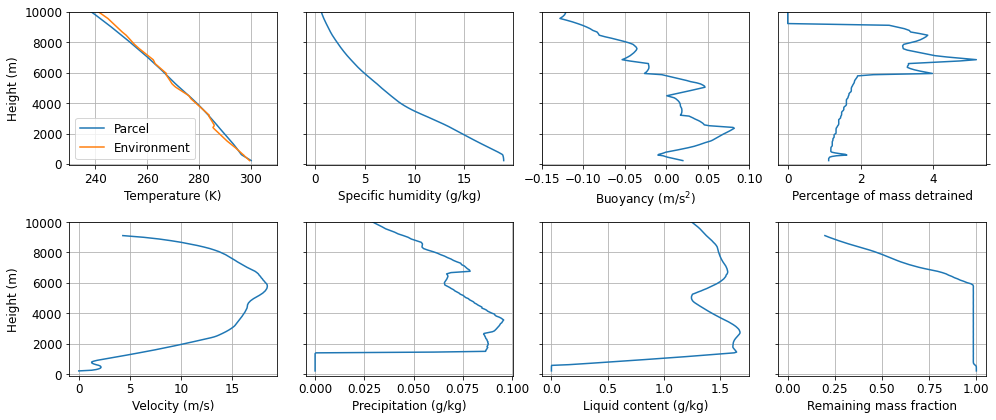

In [86]:
fig, axes = plt.subplots(2, 4, figsize=(14,6))

axes[0,0].plot(updraft.temperature, height, label='Parcel')
axes[0,0].plot(temperature, height, label='Environment')
axes[0,0].legend()
axes[0,0].set(xlabel='Temperature (K)', ylabel='Height (m)')
axes[0,0].set_xlim(230, 310)

axes[0,1].plot(updraft.specific_humidity*1e3, height)
axes[0,1].set(xlabel='Specific humidity (g/kg)', ylabel='')

axes[0,2].plot(updraft.buoyancy, height)
axes[0,2].set(xlabel='Buoyancy (m/s$^2$)', ylabel='')
axes[0,2].set_xlim(-0.15, 0.1)

axes[0,3].plot(updraft.m_detrained*1e2, height)
axes[0,3].set(xlabel='Percentage of mass detrained', ylabel='')
axes[0,3].yaxis.tick_right()

axes[1,0].plot(updraft.velocity, height)
axes[1,0].set(xlabel='Velocity (m/s)', ylabel='Height (m)')

axes[1,1].plot(updraft.precipitation*1e3, height)
axes[1,1].set(xlabel='Precipitation (g/kg)', ylabel='')

axes[1,2].plot(updraft.liquid_content*1e3, height)
axes[1,2].set(xlabel='Liquid content (g/kg)', ylabel='')

axes[1,3].plot(updraft.m_remaining, height)
axes[1,3].set(xlabel='Remaining mass fraction', ylabel='')
axes[1,3].set_xlim(-0.05, 1.05)

for ax in axes.ravel():
    ax.grid()
    ax.set_ylim(-100, 10000)

for ax in axes[:,1:].ravel():
    ax.set_yticklabels([])

fig.tight_layout()

## Low-level precipitation-driven downdrafts
Idea: colour/contour plots of maximum velocity and minimum height as functions of initiation level and precipitating layer thickness (in pressure rather than height?), for several different entrainment rates and precipitation thresholds. Indicate the levels of maximum precipitation and minimum $\theta_e$ on the plots.

In [178]:
%%time
max_precip_level = np.nanargmax(np.where(
    height > 2.5*units.km, 0, updraft.precipitation*updraft.m_remaining
))
max_precip_height = height[max_precip_level]
precip_start_level = (
    height.size - 1
    - np.searchsorted(height[::-1], max_precip_height + 1*units.km)
)
total_precip = np.nansum((
    updraft.precipitation*updraft.m_remaining
)[precip_start_level:max_precip_level+1])
downdraft = generator.downdraft(
    max_precip_level, total_precip, w_initial, rate, dnu_db, drag)

CPU times: user 248 ms, sys: 3.84 ms, total: 252 ms
Wall time: 251 ms


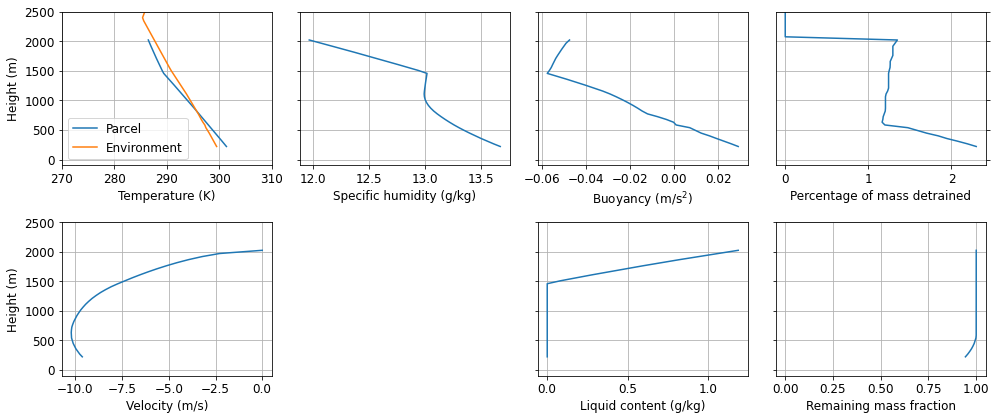

In [179]:
fig, axes = plt.subplots(2, 4, figsize=(14,6))

axes[0,0].plot(downdraft.temperature, height, label='Parcel')
axes[0,0].plot(temperature, height, label='Environment')
axes[0,0].legend()
axes[0,0].set(xlabel='Temperature (K)', ylabel='Height (m)')
axes[0,0].set_xlim(270, 310)

axes[0,1].plot(downdraft.specific_humidity*1e3, height)
axes[0,1].set(xlabel='Specific humidity (g/kg)', ylabel='')

axes[0,2].plot(downdraft.buoyancy, height)
axes[0,2].set(xlabel='Buoyancy (m/s$^2$)', ylabel='')

axes[0,3].plot(downdraft.m_detrained*1e2, height)
axes[0,3].set(xlabel='Percentage of mass detrained', ylabel='')
axes[0,3].yaxis.tick_right()

axes[1,0].plot(downdraft.velocity, height)
axes[1,0].set(xlabel='Velocity (m/s)', ylabel='Height (m)')

axes[1,2].plot(downdraft.liquid_content*1e3, height)
axes[1,2].set(xlabel='Liquid content (g/kg)', ylabel='')

axes[1,3].plot(downdraft.m_remaining, height)
axes[1,3].set(xlabel='Remaining mass fraction', ylabel='')
axes[1,3].set_xlim(-0.05, 1.05)

for ax in axes.ravel():
    ax.grid()
    ax.set_ylim(-100, 2500)

for ax in axes[:,1:].ravel():
    ax.set_yticklabels([])

axes[1,1].remove()
fig.tight_layout()

In [173]:
%%time
max_precip_level = np.nanargmax(np.where(
    height > 2.5*units.km, 0, updraft.precipitation*updraft.m_remaining
))
max_precip_height = height[max_precip_level]
precip_start_levels = range(max_precip_level - 1, -1, -1)
precip_start_heights = height[precip_start_levels]
downdrafts = np.empty(len(precip_start_levels), dtype='object')
for n, i in enumerate(precip_start_levels):
    sys.stdout.write(f'\rCalculation {n+1} of {downdrafts.size}   ')
    total_precip = np.nansum((
        updraft.precipitation*updraft.m_remaining
    )[precip_start_levels[i]:max_precip_level+1])
    downdrafts[i] = generator.downdraft(
        max_precip_level, total_precip, w_initial, rate, dnu_db, drag)
sys.stdout.write('\n')

min_heights = np.zeros(downdrafts.size)*units.meter
max_velocities = np.zeros(downdrafts.size)*units.meter/units.second
for i in range(downdrafts.size):
    min_heights[i] = np.nanmin(
        np.where(np.isnan(downdrafts[i].velocity), np.nan, height)
    )
    max_velocities[i] = np.nanmin(downdrafts[i].velocity)

Calculation 159 of 159   
CPU times: user 55.9 s, sys: 198 ms, total: 56.1 s
Wall time: 56.1 s


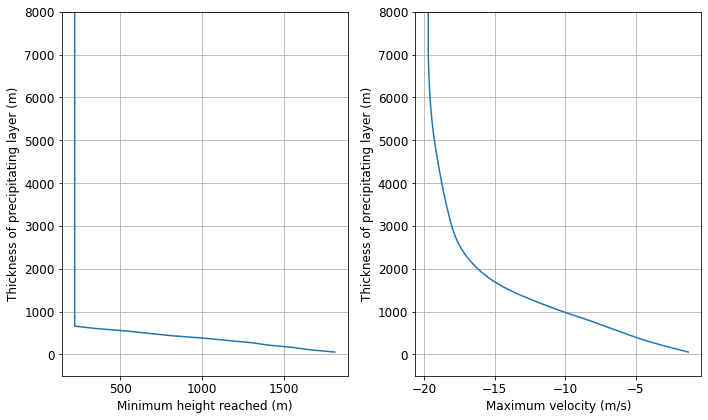

In [176]:
fig, axes = plt.subplots(1, 2, figsize=(10,6))
axes[0].plot(min_heights, precip_start_heights - max_precip_height)
axes[0].set(xlabel='Minimum height reached (m)',
            ylabel='Thickness of precipitating layer (m)')
axes[0].set_ylim(-500, 8000)
axes[0].grid()
axes[1].plot(max_velocities, precip_start_heights - max_precip_height)
axes[1].set(xlabel='Maximum velocity (m/s)',
            ylabel='Thickness of precipitating layer (m)')
axes[1].set_ylim(-500, 8000)
axes[1].grid()
fig.tight_layout()

## Elevated downdrafts from overshooting updrafts